# Getting friendly with hyperspectral Remote Sensing Reflectance
**Author:** Ryan Vandermeulen (NOAA)</br>
Last updated: January 27, 2026

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
[![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Jupyter_Hub-orange?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/vizualization_rrs.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/vizualization_rrs.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/vizualization_rrs.ipynb

## Introduction to R$_{rs}$

Remote sensing reflectance (R$_{rs}$) is the base unit of ocean color by which most products are built from, but it is also a remarkably rich dataset in its own right. Each PACE_OCI*_*AOP* Level-2 file represents a 1272 x 1709 array with (...checks notes) **172** layers of remote sensing reflectance data. Facing over 2 million data points to describe just a teeny-tiny snapshot of the Earth can feel overwhelming, leading in to confusion, light-headedness, and occasionally, loss of appetite. We can't have a generation of already disillusioned scientists running around in such a state, it's a bad image that space agencies want to avoid. However, we also don't want to be multi-spectral scientists living in a hyper-spectral world. So, how can we go about conceptualizing this data stream in a way that is informative, and takes advantage of all this extra spectral information? 

## First stop - *New PACE product* 

One new product being produced by PACE, the [**Apparent Visible Wavelength (or AVW)**](https://www.earthdata.nasa.gov/apt/documents/apparent-visible-wavelength/v1.0#doc-header), is intended to help wrangle this flood of information into something interpretable. In short, the AVW represents a one-dimensional variable that describes the weighted harmonic mean of a given R$_{rs}$ spectrum. Imagine trying to balance a single R$_{rs}$ spectrum on the tip of a pin - the wavelength where the spectrum is perfectly balanced is the AVW (units of nm). This balance point shifts proportionally in response to sublte changes in that spectrum (see animation below). As a typical rule of thumb, lower AVW values (440 - 490 nm) represent relatively clear, less productive waters while higher AVW values (490 - 600 nm) represent more turbid, productive water masses. 

![Apparent Visible Wavelength map](./Supporting_files/image2.gif)![Remote Sensing Reflectance spectra](./Supporting_files/image3.gif)


At first glance, R$_{rs}$ might feel like it sits one step removed from the ecology we ultimately want to understand. That’s a fair reaction. But before we dismiss it as “just input data,” it’s worth considering its unique utility. When we use reflectance as input to derive a higher-order geophysical product (like chlorophyll-a), we’re only drawing on a narrow slice of the spectrum, and we inherit the assumptions (and uncertainties) built into the algorithm. In contrast, examining the full spectral reflectance record allows us to see all the diagnostic signals it contains, without those assumptions. This broader view can reveal more subtle spatial and temporal patterns that connect directly to ecological change

Okay, Let's dive in and mess around with some spectra then, and see what these images are trying to tell us. By the end of this section, you will have:

> 1. Created a pretty map of the Apparent Visible Wavelength product
> 2. Drawn a customized transect on that image, and extracted a "slice" of data
> 3. Plotted up those lovely R$_{rs}$ spectra along that transect as a function of AVW values
> 4. Examined spatial variability in water color and brightness, as informed by hyperspectral data 

## *Are you ready?*

In [1]:
# If you are on Colab uncomment this and run first to install packages
#!pip install earthaccess cartopy

## Let's go get some data first

Login to NASA Earth Access

In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

For these "Level 2" files, we're downloading an individual scene, so feeding it a bounding box will help narrow down the results. For this tutorial, let's check out a scene off the coast of Louisiana, on March 5, 2025. We are explictly setting `chunk={}` so we get a dask array. This will allow our code when we integrate over wavelengths to run chunk by chunk and not exceed a 2Gb RAM instance.

In [3]:
# Level 3 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05")
)
len(results)

16

In [5]:
# here is a way to just get the urls
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250202_20250305.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250202_20250305.L3m.R32.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250210_20250313.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250210_20250313.L3m.R32.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250218_20250321.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250218_20250321.L

In [6]:
# Level 3 data filtering on file/granule name
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_LANDVI',
    temporal = ("2025-03-05", "2025-03-05"),
    granule_name="*.MO.*.4km.*"
)
len(results)

1

In [7]:
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/', '/processing_control', '/processing_control/input_parameters')

In [17]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

ValueError: These variables cannot be found in this dataset: ['longitude', 'latitude']

In [13]:
import xarray as xr
ds = xr.open_dataset(fileset[0])
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    ndvi     (lat, lon) float32 149MB ...
    evi      (lat, lon) float32 149MB ...
    ndwi     (lat, lon) float32 149MB ...
    ndii     (lat, lon) float32 149MB ...
    cci      (lat, lon) float32 149MB ...
    ndsi     (lat, lon) float32 149MB ...
    pri      (lat, lon) float32 149MB ...
    cire     (lat, lon) float32 149MB ...
    car      (lat, lon) float32 149MB ...
    mari     (lat, lon) float32 149MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/62)
    product_name:                      PACE_OCI.20250301_20250331.L3m.MO.LAND...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/LANDVI/3.1
    data_bins:                         11151571
    data_minimum:                      -508.5907
    data_maximum:                      259.3121

In [14]:
# here are the wavelengths
ds['ndvi']

<xarray.DataArray 'ndvi' (lat: 4320, lon: 8640)> Size: 149MB
[37324800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    long_name:      Normalized Difference Vegetation Index
    standard_name:  normalized_difference_vegetation_index
    valid_min:      -1000.0
    valid_max:      1000.0
    display_scale:  linear
    display_min:    -0.05
    display_max:    0.9152

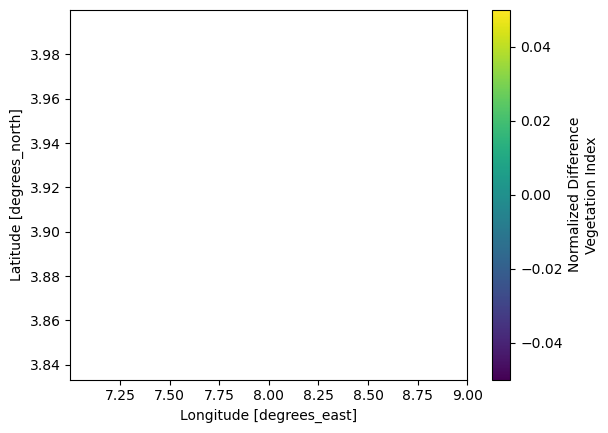

In [19]:
# Plot
ndvi = ds['ndvi']
ndvi_sub = ndvi.sel(lat=slice(4, 3.85), lon=slice(7, 9))
ndvi_sub.plot(robust=True);

In [20]:
ndvi = ds["ndvi"]

ndvi_sub = ndvi.sel(
    lat=slice(3.856667, 7.049167),
    lon=slice(3.956111, 9.040000)
)

ndvi_sub.plot(robust=True)


TypeError: No numeric data to plot.

In [24]:
bbox = (115.0, -15.0, 103.0, -2.0, )
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3_AOP",
    temporal = ("2025-06-05", "2025-06-05"),
    bounding_box = bbox
)
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/28 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/28 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/28 [00:00<?, ?it/s]

This is level 2 data and unlike level 3 data, it has groups. We need to use `open_datatree()` and `merge().

In [25]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [26]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    angstrom       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    avw            (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    nflh           (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250605T010846.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data11/sdpsoper/vdc/vpu30/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                166.35152
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9714443683624268
    geospatial_bounds:                 POLYGON ((-163.55360 -27.84841, 168.61...

In [27]:
# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 40, 12)})

## Let's open it up!

Let's load up our libraries, and then extract the relevant data we need. 

In [7]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

In [28]:
# Assign core variables; for convenience during plotting
rrs_da = ds["Rrs"]
avw_da = ds["avw"]
wavelengths = ds["wavelength_3d"]

## Mapping time!

Let's make a quick and dirty map of the AVW product to get a sense of what kind of water masses we're dealing with here, and explore what looks interesting.

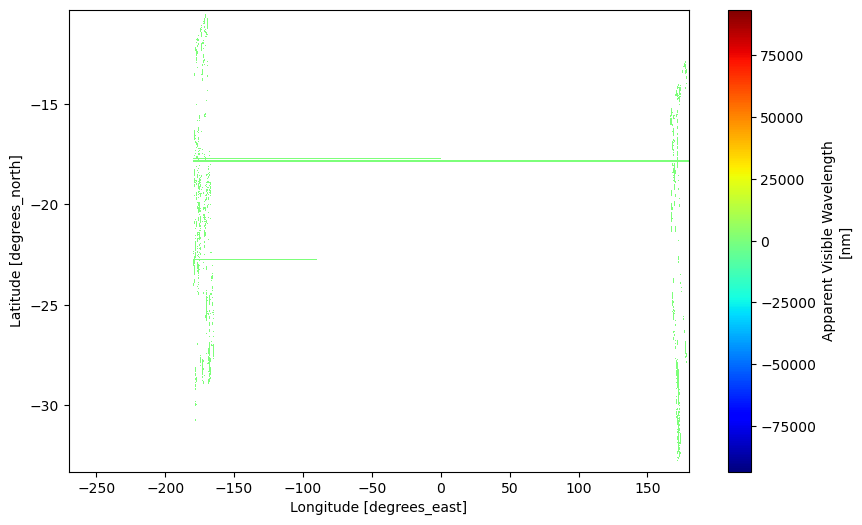

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
img = avw_da.plot(x="longitude", y="latitude", cmap="jet")

## Eww gross

Not gonna lie... this is plot makes me irrationally angry to look at. Let's add some minimal bells and whistles to this plot to make it make sense (and look a little nicer).

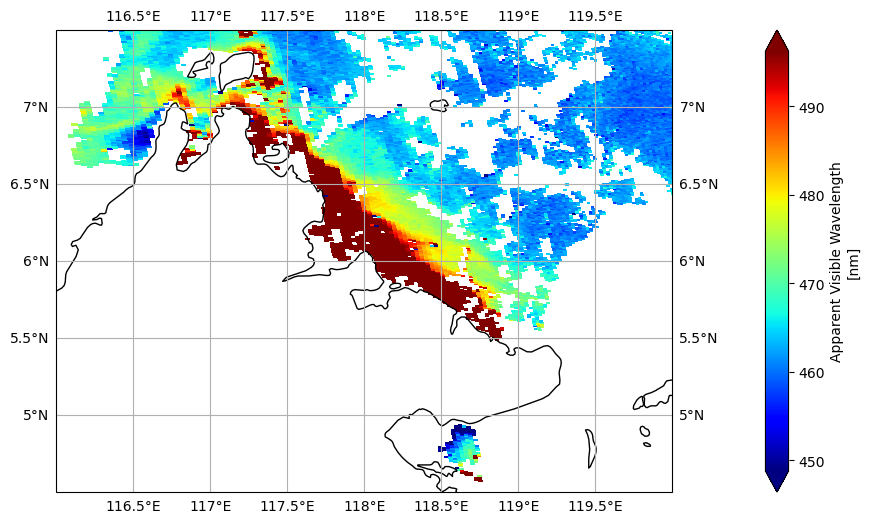

In [10]:
# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# Get the figure set up, add a map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Put some lines in there so we know where we are
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop the image down a bit so we can focus on an area
ax.set_extent([116, 120, 4.5, 7.5], crs=ccrs.PlateCarree())

# Plot and adjust colorbar limits, put "pad" argument in there to move the colorbar away from the image (otherwise it overlaps)
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, cbar_kwargs={"pad": 0.1})

That's a little better, right? Now that our disgust has subsided, we can take a moment to appreciate what’s really going on here: the meeting of the Mississippi River with the deep blue waters of the Gulf basin. The AVW gives us a first-order sense of this contrast, but beneath that, the R$_{rs}$ spectrum is full of subtle clues. Hidden in its shape are hints that help us unravel the story—whether it’s re-suspended seafloor sediments, phytoplankton blooms, dissolved organic matter, detrital materials, offshore Loop Current water, or maybe even all of the above. So let’s pop the hood on AVW and take a closer look at what the reflectance is telling us.

## Let's extract some data

Take a look at the map, and think of a starting and ending point. We're going to **build a transect** and extract the underlying data. I pre-filled some values, but feel free to put in your own start/end coordinates below, using the map grid as a reference. Keep in mind, we're in the Western Hemisphere here, so the longitudes are negative (-) values, e.g., 93°W = -93.0. 

In [11]:
# User Input: Define Transect
lat1 = 6.5
lon1 = 117.7
lat2 = 7
lon2 = 118.5

# Define transect
npts = 200  # increase/decrease for more/less detail along transect
lats = np.linspace(lat1, lat2, npts)
lons = np.linspace(lon1, lon2, npts)

What we've constructed here is essentailly two columns of lat/lon data to represent our transect. This can seamlessly be substituted with e.g., ship tracks or animal telemetry navigational data read in as "lats" and "lons" as well, should you want to adapt this. Okay, let's go ahead and put that transect on the AVW map, 1) because we can, and 2) so we can verify that the transect is where we want it.

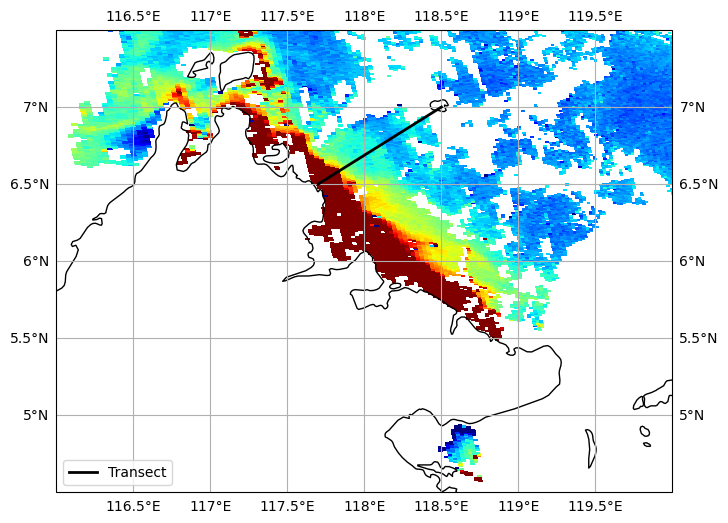

In [12]:
# Plot AVW Map and Transect
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([116, 120, 4.5, 7.5], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.plot(lons, lats, color="black", linewidth=2, transform=ccrs.PlateCarree(), label="Transect")
ax.legend(loc="lower left")
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, add_colorbar=False)

## Let's see what that extracted data looks like

Before we can look at spectra, we need to figure out which satellite pixels correspond to the lat/lon points along our transect. We're going to extract the nearest neighbors for every lat/lon we created in that transect.

In [13]:
#  Pull core variables
lat_vals = ds["latitude"].values
lon_vals = ds["longitude"].values
ny, nx = lat_vals.shape

#  Manually compute nearest pixels 
rows, cols = [], []
for lat, lon in zip(lats, lons):
    dist = np.abs(lat_vals - lat) + np.abs(lon_vals - lon)
    i, j = np.unravel_index(dist.argmin(), lat_vals.shape)
    rows.append(i)
    cols.append(j)

#  Extract data ONCE (no repeated I/O)
rrs_sel = rrs_da.isel(number_of_lines=xr.DataArray(rows, dims="points"), pixels_per_line=xr.DataArray(cols, dims="points")).load()
avw_sel = avw_da.isel(number_of_lines=xr.DataArray(rows, dims="points"), pixels_per_line=xr.DataArray(cols, dims="points")).load()

Next, for every data point that was extracted along the transect, we're going to pull together 172 layers of R$_{rs}$ information and see what each of those spectra look like. But wait, there's more! To help add some context to those spectra, we're going to make sure that we color code each individual spectrum so that it corresponds to the colormap on our AVW image. In other words, a red-colored spectrum will represent data that you pulled from a red part of the map, and so forth. 

Were going to generate two versions of this plot below. The first plot will show the Rrs spectrum "as is" in units of inverse steradians (sr$^{-1}$). In the second plot, we divided all the Rrs values by the integrated area under the spectral curve. This puts everything "equal" in terms of brightness, allowing you to focus more on absolute spectral shape differences. Both are informative in their own way, more on that in a minute.

Feel free to go back and build a new transect, explore, and get a feel for what different water masses look like.

/tmp/ipykernel_219/1382866385.py:11: RuntimeWarning: All-NaN slice encountered
  ymin = min(ymin, np.nanmin(spec_norm))
/tmp/ipykernel_219/1382866385.py:12: RuntimeWarning: All-NaN slice encountered
  ymax = max(ymax, np.nanmax(spec_norm))


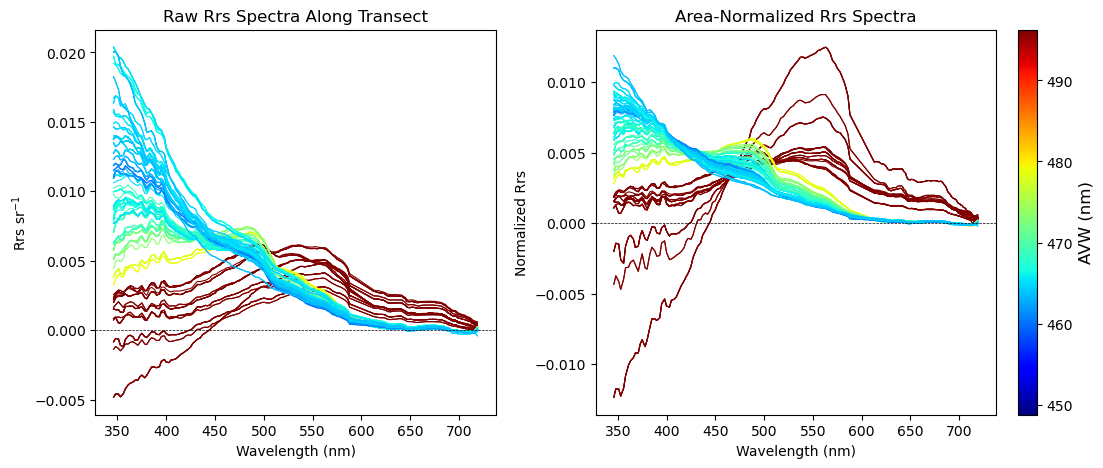

In [14]:
# Color and figure setup 
cmap = plt.get_cmap("jet")
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"wspace": 0.25})

#  Plotting 
ymin, ymax = np.inf, -np.inf
for spectrum, avw_val in zip(rrs_sel.values, avw_sel.values):
    area = trapezoid(spectrum, wavelengths)
    spec_norm = spectrum / area if area > 0 else spectrum
    ymin = min(ymin, np.nanmin(spec_norm))
    ymax = max(ymax, np.nanmax(spec_norm))
    color = cmap(norm(avw_val))
    ax_raw.plot(wavelengths, spectrum, color=color, linewidth=0.8)
    ax_norm.plot(wavelengths, spec_norm, color=color, linewidth=0.8)

#  Shared colorbar 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=(ax_raw, ax_norm), location="right", pad=0.02)
cbar.set_label("AVW (nm)", fontsize=12)

# Labels & formatting 
ax_raw.set_title("Raw Rrs Spectra Along Transect")
ax_norm.set_title("Area-Normalized Rrs Spectra")
ax_raw.set_xlabel("Wavelength (nm)")
ax_raw.set_ylabel("Rrs sr$^{-1}$")
ax_norm.set_xlabel("Wavelength (nm)")
ax_norm.set_ylabel("Normalized Rrs")
ax_norm.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))
ax_raw.axhline(0, color="black", linestyle="--", linewidth=0.5)
ax_norm.axhline(0, color="black", linestyle="--", linewidth=0.5)

plt.show()


## Bright and colorful!

As you can see from your transect plots, the optical properties of the ocean can produce substantial variability in spectral shape over a relatively short distance. On the left, the raw R$_{rs}$} is color-coded by its corresponding AVW value. On the right, we’ve removed the effect of spectral magnitude and placed everything in relative (normalized) space. This is partly an aesthetic choice, but it helps highlight differences in spectral shape (the main factor driving changes in water hue) more clearly. Importantly, whether you calculate AVW on the raw or normalized spectra, the result is the same.

That said, let’s not throw out the baby with the bathwater (an admittedly quirky American idiom). In simpler terms, we don’t want to ignore the information contained in the magnitude of R${rs}$, because AVW doesn’t capture this variance. To isolate that component, we can calculate the **total spectral magnitude** by integrating under the R${rs}$ curve using the trapezoidal rule. We did a scalar version of this above, but let’s vectorize it below to calculate it across the entire satellite image.

In [15]:
# This takes a few seconds to run
# rrs_da is a dask array (chunked). We use .compute() for force it to compute now
brightness = rrs_da.integrate(coord='wavelength_3d').compute()

Let's just do a quick comparison of the two spectral rasters - AVW (focused on spectral shape), and brightness (focused on spectral magnitude).

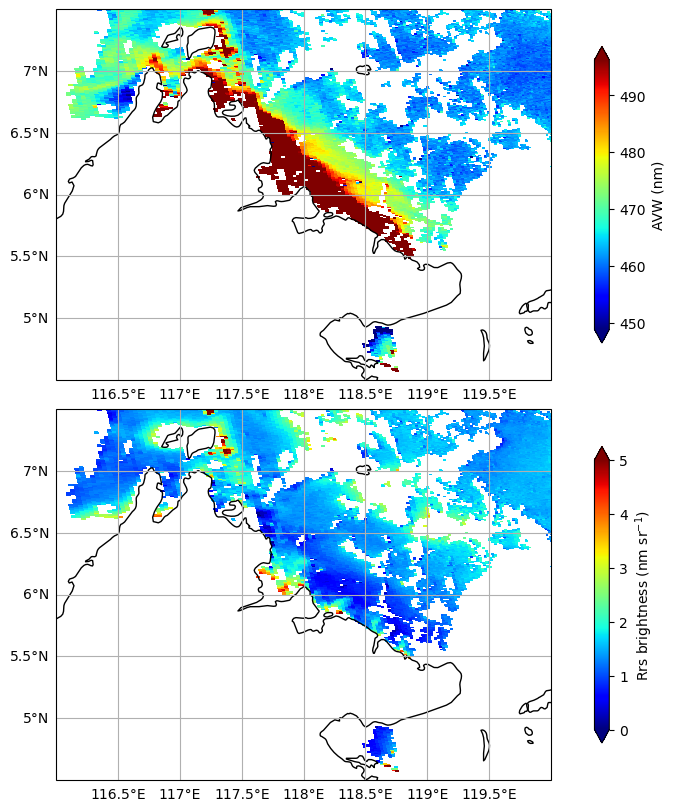

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# AVW
avw_da.plot(ax=axes[0], x="longitude", y="latitude",cmap="jet", vmin=vmin, vmax=vmax,
    cbar_kwargs={"shrink": 0.8, "label": "AVW (nm)"})
axes[0].set_extent([116, 120, 4.5, 7.5])
axes[0].coastlines()
axes[0].gridlines(draw_labels={"bottom": "x", "left": "y"})

# Brightness
brightness.plot(ax=axes[1], x="longitude", y="latitude", cmap="jet", vmin=0, vmax=5,
    cbar_kwargs={"shrink": 0.8, "label": "Rrs brightness (nm sr$^{-1}$)"})
axes[1].set_extent([116, 120, 4.5, 7.5])
axes[1].coastlines()
axes[1].gridlines(draw_labels={"bottom": "x", "left": "y"})

plt.show()

## One of these things is not like the other

Used in tandem, these indices can be a really useful diagnostic tool to help figure our where something interesting might be happening. For example: 

> Focus around 29.0, -89.5. The high AVW area just west of the Mississippi River mouth (top plot) shows lower "brightness" (bottom plot) compared to surrounding waters with similar AVW values. This could indicate that the water here is particularly rich in absorbing materials, such as dissolved organic matter, versus other times or locations where reflective sediments or clays dominate the river plume, producing a "brighter" signal (e.g., after heavy rainfall).

> Resuspended sediments offshore. Large-scale resuspension of seafloor sediments across the shelf often occurs after strong northerly winds. That may explain why these offshore waters appear "brighter" than surrounding waters. This distinction matters because the spectral shapes in both cases can look quite similar in relative (normalized) space.

> A dark patch on the shelf around 28.8, -92.5. In the original AVW image, this area blends with surrounding colors and seems unremarkable. Yet the lower brightness suggests something is absorbing photons here. Is it an isolated phytoplankton bloom? Deep water intrusion? Oil spill? We can’t tell from AVW alone, but this signal flags an area worth investigating further.

This brings us to the heart of the matter: R$_{rs}$ may not be an ecological unit in the traditional sense, but it represents habitat, capturing the first, unadulterated signs of change in the system. By examining the raw reflectance before algorithms or indices transform the data, we gain a richer, more nuanced view of the ocean—and a better chance of noticing subtle shifts that might otherwise go unseen. AVW and brightness help us interpret this complexity, but beneath them, the full reflectance spectrum is where the ocean tells its story.

## That's a wrap!

Well folks, there you have it: hyperspectral R${rs}$ data, demystified. Well, maybe not entirely, but the tools presented here can help you explore the data and get more hands-on with the raw reflectance information. Users often shy away from R${rs}$ in favor of geophysical variables that can be directly modeled in an ecosystem context, like chlorophyll-a. That’s completely understandable, but remember: every step away from the raw reflectance introduces additional uncertainty. In fact, some studies have found that using raw reflectance values can outperform more derived products, as in the case of [**modeling Atlantic Sturgeon habitat**](https://doi.org/10.1093/icesjms/fsx187). 